<a href="https://colab.research.google.com/github/arashdeep3/cap-comp215/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP 215 - PROJECT 2 (A Simple Grazing Model)**

# Name : Arashdeep Singh
# Date: 9 April 2024
The Forest Fire model is an example of how ecosystem processes can be modelled with Cellular Automata.
Another simple ecosystem process is grazing – the cycle of herbivores eating vegetation, which regenerates
between https://en.wikipedia.org/wiki/Grazing_(behaviour)
In this project, we will develop a 2D Cellular Automata model of a simple grazing system:
N deer are introduced onto a grassland and move via a random walk. The deer eat the grass which
'regrows' after a short interval. Each deer has a weight index W which can increase to a maximum M
when it is grazing and decreases when it is moving. If W reaches zero the deer dies.
The goal is to see if a stable, self-regulating deer population can be found by varying the model
parameters and initial conditions. https://scipython.com/blog/the-forest-fire-model/#comment-114

As usual, the first code cell simply imports all the modules we'll be using...

In [12]:
%matplotlib inline

import timeit
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function (from previous labs) for plotting 2D numpy.array as an image...

In [13]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

### Visualizing a 2D simulation model (from lab 6)
For 1D CAs, we could use a 2D image to visualize the CA progression over time. For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization. Instead, we'll use a simple 2D "stop motion" animation. Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state

In [14]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## **Introducing Grazing simulation class**

Next step is to introduce a class method that works as a simulation step. Make another dictionary (copy of the first one) and modify the susceptible, infected or recovered entries in the dictionary according to the probabilities given for the infection or recovery. And then simulate all the steps for the desired number of steps and call the method for the same

In [15]:
#used chatgpt for debugging and to learn some new things like "YlGn" ,"numpy.clip" ,"numpy.full","marker='o'"
class GrazingSimulation:
    """
    2D Cellular Automaton model for grazing simulation.

    Parameters:
    - size: Size of the grid.
    - count: Number of deer in the simulation.
    - regrowth_rate: Rate at which vegetation regrows.
    - max_weight: Maximum weight of a deer.
    """
    # Define correlation kernel for vegetation and deer influence
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]])


    def __init__(self, size=50, count=10, regrowth_rate=0.1, max_weight=10):
        self.size = size
        self.count = count
        self.vegetation = np.ones((size, size))
        self.weights = np.full((size, size), max_weight, dtype=float)
        self.max_weight = max_weight
        self.regrowth_rate = regrowth_rate
        self.positions = np.random.randint(0, size, size=(count, 2))

    def regen_vegetation(self):
        """Regenerates vegetation on the grid."""
        self.vegetation += self.regrowth_rate
        self.vegetation = np.minimum(self.vegetation, 1)

    def move_deer(self):
        """Moves deer randomly on the grid."""
        for i in range(self.count):
            direction = np.random.randint(-1, 2, size=2)
            new_pos = self.positions[i] + direction
            new_pos = np.clip(new_pos, 0, self.size - 1)
            self.positions[i] = new_pos

    def update(self):
        """Updates the simulation for one time step."""
        self.regen_vegetation()
        self.move_deer()
        self.feed_deer()
        self.weights -= 0.1
        self.weights = np.maximum(self.weights, 0)

    def feed_deer(self):
        """
        Feeds deer based on their proximity to vegetation.

        Deer consume vegetation based on their proximity to it, influenced by the vegetation and deer kernels.
        """
        veg_influence = correlate2d(self.vegetation,self.kernel, mode='same', boundary='wrap')
        deer_influence = correlate2d(self.weights, self.kernel, mode='same', boundary='wrap')

        deer_proximity = np.zeros_like(self.vegetation)
        for x, y in self.positions:
            deer_proximity[x, y] += 1

        deer_proximity = deer_proximity / np.max(deer_proximity)

        for i, (x, y) in enumerate(self.positions):
            if self.vegetation[x, y] > 0:
                consumption = veg_influence[x, y] * deer_proximity[x, y] * 0.5
                self.weights[x, y] = min(self.weights[x, y] + consumption, self.max_weight)
                self.vegetation[x, y] -= consumption

    def step(self):
        """Advances the simulation by one time step."""
        self.update()

    def under_growth_cells(self):
        """Counts the number of empty cells (cells with zero vegetation density) in the grid."""
        empty = np.where(self.vegetation < 1)
        return empty[0].shape[0]

    def draw(self, ax, step):
        """
        Draws the CA cells using the plot_2d_array function.

        Parameters:
            ax (matplotlib.axes.Axes): Matplotlib axes to draw on.
            step (int): Integer step number.
        """
        ax.clear()
        # Adjust the vmin and vmax values to match the range of data values
        plot_2d_array(self.vegetation, axes=ax, title=f'Grazing Simulation (Step {step})', cmap="YlGn", vmin=0, vmax=1)
        ax.scatter(self.positions[:, 1], self.positions[:, 0], color='brown', marker='o', label='Deer')
        ax.legend()

#Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics

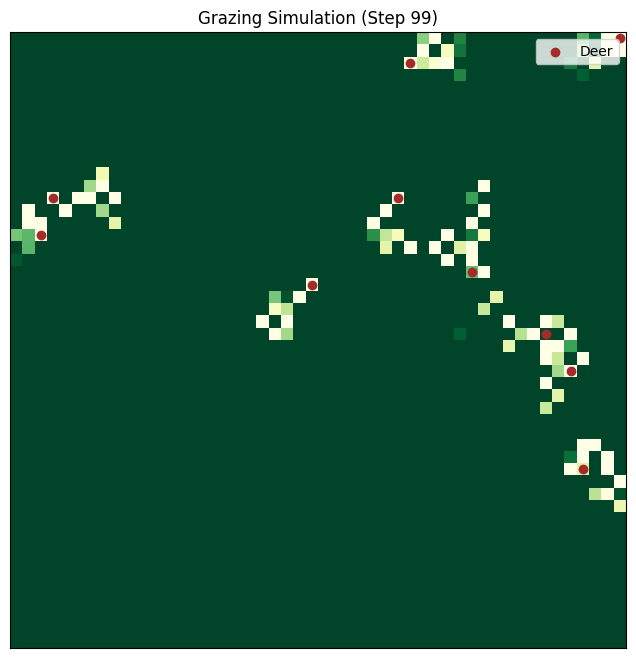

In [16]:
# Create a GrazingSimulation instance
simulation = GrazingSimulation(size=50, count=10, regrowth_rate=0.1, max_weight=10)

# Create a Animation2D instance
anim = Animation2D(simulation, frames=100)

# Show the animation
anim.animate()

## **Temporal Dynamics: Stability and Equilibrium**

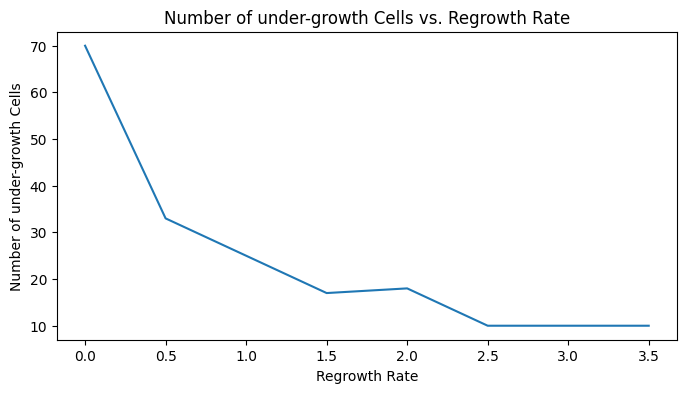

In [17]:
def experiment_regrowth_rate(regrowth_rates):
    """
    Conducts experiments varying the regrowth rate while keeping the maximum weight constant.
    """
    results = {}

    for regrowth_rate in regrowth_rates:
        sim = GrazingSimulation(size=100, count=10, regrowth_rate=regrowth_rate, max_weight=10)
        for i in range(10):
          sim.step()
        results[regrowth_rate]=sim.under_growth_cells()

    return results


regrowth_rates = np.arange(0, 4, 0.5)

results_regrowth = experiment_regrowth_rate(regrowth_rates)

# Plot results for regrowth rate experiment
plt.figure(figsize=(8,4))
plt.plot(results_regrowth.keys(), results_regrowth.values())
plt.xlabel('Regrowth Rate')
plt.ylabel('Number of under-growth Cells')
plt.title('Number of under-growth Cells vs. Regrowth Rate')
plt.show()


As the vegetation growth rate increased, the number of cells, which are under growth, in the grazing simulation decreased, stabilizing around 10 after reaching a rate of 2.5. This reflects a self-regulating behavior, where higher growth rates initially reduce under-growth cells, but stabilize as vegetation sustains the deer population.

# **Big-o notation**
The overall time complexity of the algorithm is O(size^2 * count). This means that as the size of the grid or the number of deer increases, the time it takes to simulate each step of the GrazingSimulation system will grow quadratically.


In summary, the time complexity of the algorithm affects the scalability and efficiency of running larger or longer CA experiments. Lower time complexity implies better scalability and faster execution times, while higher time complexity leads to longer simulation times and potential performance issues when scaling up the experiments. (used chatgpt)

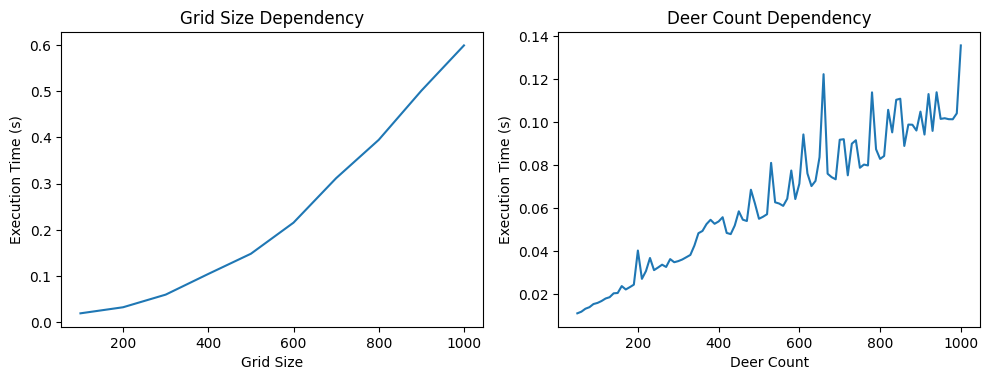

In [21]:
# Define parameters
grid_sizes = range(100, 1001, 100)
deer_counts = range(50, 1001, 10)

# Time execution for grid sizes
grid_execution_times = {}
for size in grid_sizes:
    simulation = GrazingSimulation(size=size, count=100)
    time_taken = timeit.timeit(simulation.step, number=5)
    grid_execution_times[size] = time_taken

# Time execution for deer counts
count_execution_times = {}
for count in deer_counts:
    simulation = GrazingSimulation(size=100, count=count)
    time_taken = timeit.timeit(simulation.step, number=5)
    count_execution_times[count] = time_taken

# Plot results for grid size
plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
plt.plot(list(grid_execution_times.keys()), list(grid_execution_times.values()))
plt.xlabel('Grid Size')
plt.ylabel('Execution Time (s)')
plt.title('Grid Size Dependency')
plt.tight_layout()

# Plot results for deer count
plt.subplot(2, 2, 2)
plt.plot(list(count_execution_times.keys()), list(count_execution_times.values()))
plt.xlabel('Deer Count')
plt.ylabel('Execution Time (s)')
plt.title('Deer Count Dependency')
plt.tight_layout()

plt.show()